<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2019/blob/master/100_epochs_Tiny_Imagenet_fastai_45_Valid_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip  tiny-imagenet-200/val/* 
!unzip -q tiny-imagenet-200.zip  tiny-imagenet-200/train/*

Updating fastai...
Done.
--2019-05-03 05:43:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  93.0MB/s    in 2.5s    

2019-05-03 05:43:48 (93.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
from fastai.vision import Path
PATH_TRN = Path('/content/tiny-imagenet-200/train')
PATH_VAL = Path('/content/tiny-imagenet-200/val')

In [0]:
#move all filess in tiny-imagenet-200/train/n0000/images/ to tiny-imagenet-200/train/n0000/

import os,shutil, sys  
for root, dirs, files in os.walk(PATH_TRN):
    for dr in dirs:
        if dr == "images":
            dr = root+"/"+dr
            # direct superior directory
            up = dr[:dr.rfind("/")]
            # move files from lowest level one level up
            for f in os.listdir(dr):
                shutil.move(dr+"/"+f, up+"/"+f)
                
def create_val_folder():
    path = PATH_VAL/'images'
    filename = PATH_VAL/'val_annotations.txt'
    fp = open(filename, "r")  # open file in read mode
    data = fp.readlines()  # read line by line

    # Create a dictionary with image names as key and corresponding classes as values
    val_img_dict = {}
    for line in data:
        words = line.split("\t")
        val_img_dict[words[0]] = words[1]
    fp.close()

    # Create folder if not present, and move image into proper folder
    for img, folder in val_img_dict.items():
        newpath = (os.path.join(path, folder))
        if not os.path.exists(newpath):  # check if folder exists
            os.makedirs(newpath)

        if os.path.exists(os.path.join(path, img)):  # Check if image exists in default directory
            os.rename(os.path.join(path, img), os.path.join(newpath, img))

create_val_folder()  

In [0]:
!mv /content/tiny-imagenet-200/val/images/* /content/tiny-imagenet-200/val/
!rm -rf /content/tiny-imagenet-200/val/images


In [0]:
from fastai.vision import *
PATH = Path('/content/tiny-imagenet-200')
il = ImageList.from_folder(PATH)
sd = il.split_by_folder(train='train', valid='val')
ll = sd.label_from_folder()

In [0]:
ll=ll.transform(get_transforms(),size=16)
bs = 2048//2
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(3, 64),    
    conv_and_res(64, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 256),
    conv_and_res(256, 200),
    conv2(200, 200),
    Flatten()
)

In [0]:
from fastai.callbacks import ReduceLROnPlateauCallback,SaveModelCallback,EarlyStoppingCallback

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


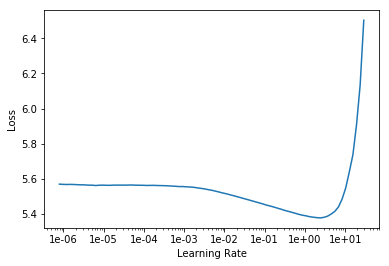

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.callback_fns.append(partial(ReduceLROnPlateauCallback, min_delta=1e-3, patience=2))
learn.callback_fns.append(partial(SaveModelCallback,monitor='val_loss',mode='min', name='stage-16'))
learn.callback_fns.append(partial(EarlyStoppingCallback,monitor='val_loss',patience = 5))
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
lr=1e-2
learn.fit_one_cycle(32, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.308076,5.229002,0.018300,01:54
1,5.078135,4.961446,0.040700,01:56
2,4.829848,4.693896,0.061800,01:54
3,4.608782,4.599228,0.077700,01:55
4,4.401517,4.406595,0.097900,01:57
5,4.206268,4.229718,0.120000,01:59
6,4.042176,4.013574,0.145400,02:00
7,3.888277,3.874768,0.159500,01:59
8,3.766331,3.844429,0.169200,02:01
9,3.661791,3.684695,0.195000,01:58


Better model found at epoch 0 with val_loss value: 5.229002475738525.
Better model found at epoch 1 with val_loss value: 4.961446285247803.
Better model found at epoch 2 with val_loss value: 4.693896293640137.
Better model found at epoch 3 with val_loss value: 4.599228382110596.
Better model found at epoch 4 with val_loss value: 4.406595230102539.
Better model found at epoch 5 with val_loss value: 4.22971773147583.
Better model found at epoch 6 with val_loss value: 4.01357364654541.
Better model found at epoch 7 with val_loss value: 3.8747682571411133.
Better model found at epoch 8 with val_loss value: 3.844428539276123.
Better model found at epoch 9 with val_loss value: 3.684695243835449.
Better model found at epoch 10 with val_loss value: 3.6331069469451904.
Better model found at epoch 11 with val_loss value: 3.5192511081695557.
Better model found at epoch 12 with val_loss value: 3.4684360027313232.
Better model found at epoch 14 with val_loss value: 3.4082324504852295.
Better model 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


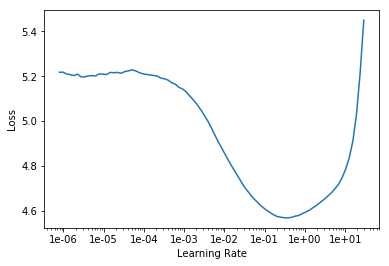

In [0]:
ll = sd.label_from_folder()
ll=ll.transform(get_transforms(),size=32)
bs = 2048//2
data = ll.databunch(bs=bs).normalize(imagenet_stats)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.callback_fns.append(partial(ReduceLROnPlateauCallback, min_delta=1e-2, patience=2))
learn.callback_fns.append(partial(SaveModelCallback,monitor='val_loss',mode='min', name='stage-32'))
learn.callback_fns.append(partial(EarlyStoppingCallback,monitor='val_loss',patience = 5))
learn=learn.load('stage-16')
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
lr=1e-2
learn.fit_one_cycle(32, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.965569,3.625761,0.194000,02:01
1,3.298284,3.172472,0.270300,02:00
2,2.963585,3.014633,0.303500,02:01
3,2.808969,2.981061,0.309200,02:00
4,2.745691,2.969253,0.312700,02:02
5,2.717375,3.010451,0.307600,01:59
6,2.694105,2.961189,0.317100,02:01
7,2.667308,3.005731,0.309600,02:02
8,2.647022,2.952501,0.317800,02:01
9,2.599494,2.973925,0.321000,02:01


Better model found at epoch 0 with val_loss value: 3.625761032104492.
Better model found at epoch 1 with val_loss value: 3.1724722385406494.
Better model found at epoch 2 with val_loss value: 3.0146329402923584.
Better model found at epoch 3 with val_loss value: 2.9810612201690674.
Better model found at epoch 4 with val_loss value: 2.9692533016204834.
Better model found at epoch 6 with val_loss value: 2.961189031600952.
Epoch 7: reducing lr to 0.0018716542103917367
Better model found at epoch 8 with val_loss value: 2.952501058578491.
Better model found at epoch 10 with val_loss value: 2.8987159729003906.
Better model found at epoch 11 with val_loss value: 2.856706142425537.
Better model found at epoch 12 with val_loss value: 2.83304500579834.
Better model found at epoch 14 with val_loss value: 2.8065433502197266.
Better model found at epoch 15 with val_loss value: 2.7655582427978516.
Better model found at epoch 17 with val_loss value: 2.743730306625366.
Epoch 20: reducing lr to 0.00097

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


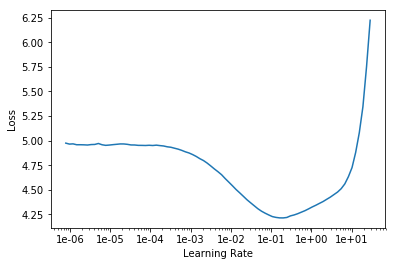

In [0]:
ll = sd.label_from_folder()
ll=ll.transform(get_transforms(),size=64)
bs = 2048//2
data = ll.databunch(bs=bs).normalize(imagenet_stats)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.callback_fns.append(partial(ReduceLROnPlateauCallback, min_delta=1e-2, patience=2))
learn.callback_fns.append(partial(SaveModelCallback,monitor='val_loss',mode='min', name='stage-64'))
learn.callback_fns.append(partial(EarlyStoppingCallback,monitor='accuracy',patience = 5))
learn=learn.load('stage-32')
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
lr=1e-2
learn.fit_one_cycle(32, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.612001,3.828073,0.183900,02:34
1,2.849441,3.110404,0.280600,02:38
2,2.432498,2.852537,0.333500,02:34
3,2.244106,2.785127,0.353600,02:35
4,2.166128,2.780444,0.354200,02:32
5,2.137752,2.830482,0.356100,02:35
6,2.135526,2.812394,0.356700,02:34
7,2.112318,2.811844,0.358900,02:35
8,2.095780,2.766390,0.362000,02:34
9,2.038801,2.722838,0.373800,02:34


Better model found at epoch 0 with val_loss value: 3.8280725479125977.
Better model found at epoch 1 with val_loss value: 3.1104040145874023.
Better model found at epoch 2 with val_loss value: 2.852537155151367.
Better model found at epoch 3 with val_loss value: 2.7851269245147705.
Better model found at epoch 4 with val_loss value: 2.780444383621216.
Epoch 6: reducing lr to 0.0016733270899621255
Better model found at epoch 8 with val_loss value: 2.766390323638916.
Better model found at epoch 9 with val_loss value: 2.7228384017944336.
Better model found at epoch 10 with val_loss value: 2.706076145172119.
Better model found at epoch 13 with val_loss value: 2.6199839115142822.
Epoch 16: reducing lr to 0.001507910531681978
Epoch 19: reducing lr to 0.0011118141008053266
Epoch 19: early stopping


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


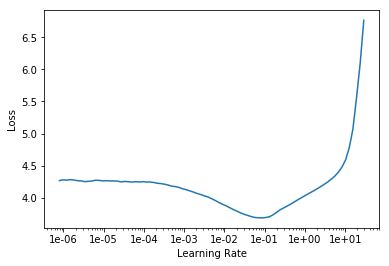

In [0]:
ll = sd.label_from_folder()
ll=ll.transform(get_transforms(),size=112)
bs = 2048//4
data = ll.databunch(bs=bs).normalize(imagenet_stats)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.callback_fns.append(partial(ReduceLROnPlateauCallback, min_delta=1e-2, patience=2))
learn.callback_fns.append(partial(SaveModelCallback,monitor='val_loss',mode='min', name='stage-112'))
learn.callback_fns.append(partial(EarlyStoppingCallback,monitor='accuracy',patience = 5))
learn=learn.load('stage-64')
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
lr=1e-3
learn.fit_one_cycle(32, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.697146,3.683738,0.239600,04:19
1,3.187777,3.223653,0.284900,04:18
2,2.735895,2.834409,0.343000,04:20
3,2.366611,2.566164,0.390300,04:21
4,2.130025,2.419227,0.425200,04:20
5,1.953004,2.369150,0.436500,04:21
6,1.835300,2.343538,0.446100,04:20
7,1.746105,2.330222,0.453200,04:20
8,1.667852,2.348142,0.453200,04:22
9,1.600166,2.351248,0.453300,04:21


Better model found at epoch 0 with val_loss value: 3.6837375164031982.
Better model found at epoch 1 with val_loss value: 3.2236530780792236.
Better model found at epoch 2 with val_loss value: 2.834409236907959.
Better model found at epoch 3 with val_loss value: 2.566164016723633.
Better model found at epoch 4 with val_loss value: 2.419227361679077.
Better model found at epoch 5 with val_loss value: 2.369150161743164.
Better model found at epoch 6 with val_loss value: 2.3435375690460205.
Better model found at epoch 7 with val_loss value: 2.3302221298217773.
Epoch 10: reducing lr to 0.0001980785357262109
Epoch 13: reducing lr to 0.00018155616067157843
Epoch 16: reducing lr to 0.00015080773129451483
Epoch 19: reducing lr to 0.00011119680282454034
Epoch 20: early stopping


In [0]:
ll = sd.label_from_folder()
ll=ll.transform(get_transforms(),size=112)
bs = 2048//4
data = ll.databunch(bs=bs).normalize(imagenet_stats)
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn=learn.load('stage-112')

In [0]:
#Validation Accuracy
learn.validate(learn.data.valid_dl)

[2.3302221, tensor(0.4532)]